# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [1]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp 

%matplotlib inline

# Einlesen mit h5py

In [2]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [3]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None


## Daten einlesen mit pyfact

In [4]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

# Limits für theata^2 - Plot

In [1]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

NameError: name 'np' is not defined

In [6]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [7]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [8]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


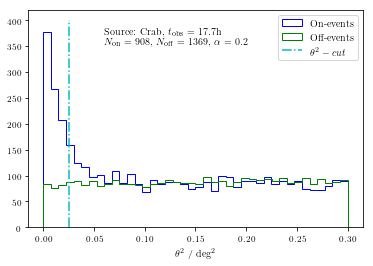

In [9]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))
plt.savefig('On_Off.pdf')
print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

In [10]:
max_bin = max(max(gammas_sel['gamma_energy_prediction']), max(gammas_sel['corsika_event_header_total_energy']))
min_bin = min(min(gammas_sel['gamma_energy_prediction']), min(gammas_sel['corsika_event_header_total_energy']))
print(min_bin)
if max_bin <= max(np.logspace(np.log10(500),np.log10(20e3),11)):
    print('Durch obere binning Grenze werden keine events aussortiert, da höchster vorkommender Wert: {}!'.format(max_bin))
    b = 12
    bins1 = np.ones(b)
else:
    b = 13
    bins1 = np.ones(b)
    bins1[-1] = 50e3
bins1[0] = 0

for i in range(1, b-1, 1):
    bins1[i] = np.logspace(np.log10(500),np.log10(15e3),11)[i-1]
print(bins1)

205.58768
[    0.           500.           702.55791324   987.17524292
  1387.09555734  1949.02992046  2738.61278753  3848.06817036
  5406.98148757  7597.43526168 10675.27652687 15000.
 50000.        ]


In [11]:
bins2 = np.ones(8)
bins2[0] = 0
for i in range(1, 7, 1):
    bins2[i] = np.logspace(np.log10(500),np.log10(15e3),6)[i-1]
bins2[-1] = 50e3
print(bins2)

[    0.           500.           987.17524292  1949.02992046
  3848.06817036  7597.43526168 15000.         50000.        ]


Matrix hat neue shape:  (12, 7)


<Figure size 432x288 with 0 Axes>

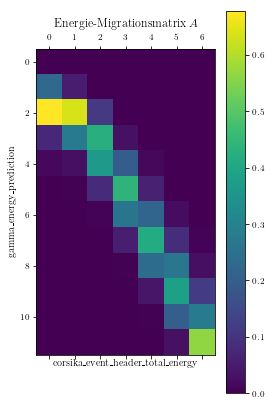

In [12]:
plt.figure(constrained_layout=True)
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             bins1,
                                             bins2,
                                         ])
matrix = matrix/np.sum(matrix,axis=0) #hier erfolgt die Normierung
plt.matshow(matrix)
plt.ylabel('gamma\_energy\_prediction')
plt.xlabel('corsika\_event\_header\_total\_energy')
plt.title('Energie-Migrationsmatrix $A$')
plt.colorbar()
plt.savefig('Matrix.pdf')
print('Matrix hat neue shape: ', np.shape(matrix))

[    0.           500.           702.55791324   987.17524292
  1387.09555734  1949.02992046  2738.61278753  3848.06817036
  5406.98148757  7597.43526168 10675.27652687 15000.
 50000.        ]
[    0.           500.           702.55791324   987.17524292
  1387.09555734  1949.02992046  2738.61278753  3848.06817036
  5406.98148757  7597.43526168 10675.27652687 15000.
 50000.        ]


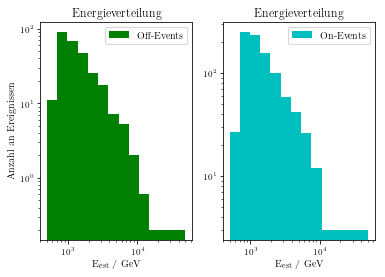

In [14]:
# Untergrund binnen
plt.subplot(1,2,1)
a = np.full_like(bkg['gamma_energy_prediction'], 0.2)
b, bins_b, p = plt.hist(bkg['gamma_energy_prediction'],
                        bins=xedge,
                        weights=a,
                        color='g',
                        label='Off-Events'
                       )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_\mathrm{est}$ / GeV')
plt.ylabel('Anzahl an Ereignissen')
plt.legend()
plt.title('Energieverteilung')
plt.subplot(1,2,2)
g, bins_g, p = plt.hist(crab_events_sel['gamma_energy_prediction'],
                        bins=xedge,
                        color='c',
                        label='On-Events')
print(bins_b)
print(bins_g)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_\mathrm{est}$ / GeV')
plt.legend()
plt.title('Energieverteilung')
plt.savefig('Energieverteilung_UG_SIG.pdf')

In [15]:
matrix.shape

(12, 7)

In [16]:
# Penrose-Moore Pseudoinverse ausrechnen (nicht quadratisch)
inv = unp.ulinalg.pinv(matrix)
print(inv)

[[ 2.76653343e-15  3.67026028e+00  3.70914269e-01 -1.72583365e+00
   1.99119817e+00 -5.31961583e-01 -4.76535113e-01  2.09981307e-01
   1.25408197e-01 -8.48608370e-02 -4.48368334e-02  3.34308740e-02]
 [-3.39599798e-15 -3.90480604e+00  1.18115318e+00  1.88410598e+00
  -2.70024946e+00  7.40921917e-01  6.55078307e-01 -2.88991971e-01
  -1.72498058e-01  1.16701059e-01  6.16657960e-02 -4.59724567e-02]
 [ 1.26461745e-15  1.25722623e+00 -5.66334524e-01  8.53045349e-01
   2.07471393e+00 -7.04717127e-01 -5.58180686e-01  2.49845354e-01
   1.48037729e-01 -1.00180316e-01 -5.29527431e-02  3.94440485e-02]
 [-3.28865404e-16 -4.38839092e-01  1.87265067e-01 -3.56133814e-01
  -9.58822486e-02  1.89596004e+00  8.69905052e-01 -5.90367604e-01
  -3.00161403e-01  2.26239202e-01  1.17069325e-01 -8.80127757e-02]
 [ 1.84742110e-16  1.50361191e-01 -6.33239475e-02  1.20318885e-01
  -2.02659416e-03 -5.87120043e-01  5.46667820e-01  1.91946632e+00
   6.13331628e-01 -7.26104744e-01 -3.47997849e-01  2.75104735e-01]
 [ 7.

In [17]:
from uncertainties import ufloat

g_unc = np.array([ufloat(x, np.sqrt(x)) for x in g])
b_unc = np.array([ufloat(x, np.sqrt(x)) for x in b])

In [18]:
# Naive Entfaltung
ev = g-b
ev_unc = g_unc - b_unc
fNSVD = inv@ev
fNSVD_unc = inv.dot(ev_unc)[1:-1]
print(fNSVD_unc)
print(fNSVD)
fNSVD = fNSVD[1:-1]
print('fNSVD:', fNSVD)


[210.21412235374993+/-60.875968377529844
 235.6070262755301+/-36.73728066611528
 102.47084227890039+/-24.205279710878415
 63.463460731839945+/-16.530707158186434
 16.90320038755621+/-9.938095967118661]
[ -0.31269851 210.21412235 235.60702628 102.47084228  63.46346073
  16.90320039   2.57228695]
fNSVD: [210.21412235 235.60702628 102.47084228  63.46346073  16.90320039]


In [19]:
xpos=[yedge[i]-(yedge[i] - yedge[i-1])/2 for i in range(1,len(yedge))]
xpos=xpos[1:-1]
xerr=[(yedge[i] - yedge[i-1])/2 for i in range(2,len(yedge)-1)]

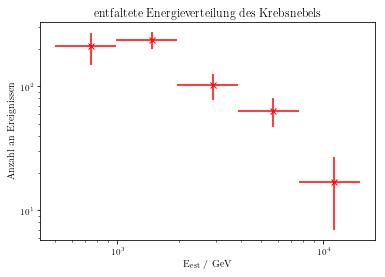

In [22]:
plt.errorbar(xpos, [x.nominal_value for x in fNSVD_unc], xerr=xerr, yerr=[x.std_dev for x in fNSVD_unc], fmt='rx')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_\mathrm{est}$ / GeV')
plt.ylabel('Anzahl an Ereignissen')
plt.title('entfaltete Energieverteilung des Krebsnebels')
plt.savefig('Entfaltung_1.pdf')

In [23]:
# negative Log-Likelihood-Entfaltung
def NegLog(f, A, b, g):
    lam = A@f + b
    return -poisson.logpmf(g, lam).sum()

f, yedges = np.histogram(gammas_sel['gamma_energy_prediction'], bins=yedge)

Bounds= [(1,100000)]*len(f)

estimator = minimize(NegLog, f+100, args=(matrix, b, g), method='L-BFGS-B', bounds=Bounds)
#print(estimator)
#Schätzer
fLike = estimator['x']
fLike_plot = estimator['x'][1:-1]
print('Schätzer:', fLike_plot)
#print('yedge: ', yedge)

#Hessematrix aus Minimize für Fehlerrechnung auf Schätzer
Hess_Inv = estimator['hess_inv'].todense()
print('Kovarianzmatrix:',Hess_Inv)
print('Kovarianzmatrix:',np.shape(Hess_Inv))

Schätzer: [188.78508209 241.04343439  99.48449476  67.19670471  13.37411857]
Kovarianzmatrix: [[ 6.19602198e+02 -8.43213982e+02  2.11449546e+02 -3.05775813e-01
   2.34394379e+01 -2.83058585e+01 -1.51747265e+01]
 [-8.43213982e+02  1.70330255e+03 -6.56440221e+02  1.06198674e+02
  -2.86176932e+01  3.11178976e+01  1.11893458e+01]
 [ 2.11449546e+02 -6.56440221e+02  9.80625542e+02 -2.41245001e+02
   5.66992479e+01 -2.91424919e+01  9.77365923e+00]
 [-3.05775813e-01  1.06198674e+02 -2.41245001e+02  3.50434607e+02
  -1.29216890e+02  4.09883083e+01 -1.21814808e+01]
 [ 2.34394379e+01 -2.86176932e+01  5.66992479e+01 -1.29216890e+02
   1.59525042e+02 -2.31300929e+01  3.30303056e+00]
 [-2.83058585e+01  3.11178976e+01 -2.91424919e+01  4.09883083e+01
  -2.31300929e+01  2.93673494e+01 -1.97300985e+00]
 [-1.51747265e+01  1.11893458e+01  9.77365923e+00 -1.21814808e+01
   3.30303056e+00 -1.97300985e+00  1.34825028e+01]]
Kovarianzmatrix: (7, 7)


In [24]:
diag_kov = np.diag(Hess_Inv)
diag_kov_sqrt = np.sqrt(diag_kov)
print(diag_kov_sqrt[1:-1])

[41.27108609 31.3149412  18.71989869 12.63032231  5.41916501]


In [25]:
#Zufallszahlen mit Multivarianten Gauss 
fLike_Var = np.random.multivariate_normal(fLike, Hess_Inv, size=10000)
fLike_Var = fLike_Var[:,1:-1]
fLike_Var[:, 0]
std_devs = np.ones(5)
for i in range(5):
    std_devs[i] = np.std(fLike_Var[:, i])
print(std_devs)

[40.81380484 31.21904216 18.71661831 12.73007937  5.35965525]


In [26]:
std_devs = diag_kov_sqrt[1:-1]

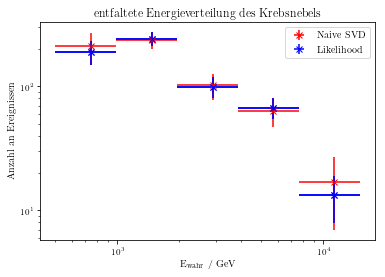

In [27]:
plt.errorbar(xpos, fLike_plot, xerr=xerr, yerr = std_devs, fmt='bx')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_\mathrm{wahr}$ / GeV')
plt.ylabel('Anzahl an Ereignissen')
plt.title('entfaltete Energieverteilung des Krebsnebels')
plt.savefig('Entfaltung_2.pdf')

plt.errorbar(xpos, fNSVD, xerr=xerr, yerr=[x.std_dev for x in fNSVD_unc], fmt='rx', label='Naive SVD')
plt.errorbar(xpos, fLike_plot, xerr=xerr, yerr = std_devs, fmt='bx', label='Likelihood')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mathrm{E}_\mathrm{wahr}$ / GeV')
plt.ylabel('Anzahl an Ereignissen')
plt.title('entfaltete Energieverteilung des Krebsnebels')
plt.legend()
plt.savefig('Entfaltung_VGL.pdf')

In [28]:
def fluss(f, A, dE, t):
    return f/(A*dE*t)

t_obs = crab_runs['ontime'].sum()

In [29]:
#Breite des Energie-bins 
Delta_E = np.diff(yedge[1:-1])*10**(-3)
Delta_E

array([0.48717524, 0.96185468, 1.89903825, 3.74936709, 7.40256474])

In [ ]:
# Detektorfläche für A_eff
A = np.pi * 27000**2 
# Bestimmung von N_sel/N_sim
hist_sel, yedges = np.histogram(gammas_sel['gamma_energy_prediction'], bins=yedge)
print(hist_sel)
hist_sim, yedges = np.histogram(gammas_corsika['total_energy'], bins=yedge)
print(hist_sim)
#Bestimmung der effektiven Fläche
A_eff = hist_sel[1:-1]/hist_sim[1:-1] * A /0.7
print('A_eff=',A_eff)

In [ ]:
#Berechnung des Flusswertes
phi_NSVD = fNSVD_unc/(A_eff * Delta_E * t_obs)
phi_Like = fLike_plot/(A_eff * Delta_E * t_obs)

#Mittelwert und Standardabweichung
phi_Like_Var = fLike_Var/(A_eff * Delta_E * t_obs)
mean = phi_Like_Var.mean(axis=0)
std = phi_Like_Var.std(axis=0)
print('Phi_NSVD:', phi_NSVD)
print('Phi_Like:', phi_Like)
print('Mean:',mean)
print('Std:',std)

In [ ]:
plt.errorbar(xpos, [x.nominal_value for x in phi_NSVD], xerr=xerr, yerr=[x.std_dev for x in phi_NSVD], fmt ='rx', label='Naive SVD')
plt.errorbar(xpos, phi_Like, xerr=xerr, yerr=std, fmt ='bx', label='Likelihood') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie$_\mathrm{wahr}$ /GeV')
plt.ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}E \, \mathrm{d}A \, t_{obs}}$ [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.savefig('Fluss.pdf')

In [ ]:
def func(x, a, b, c, d):
     return a * (x/b) ** (-c + d * np.log(x/b))

In [ ]:
x = np.linspace(450, 17000, 10000)
y = func(x, 3.23*10**(-11), 1000, 2.47,-0.24)
plt.plot(x, y, 'm-', label='MAGIC')                         
plt.errorbar(xpos, mean, yerr = std, xerr=xerr, fmt='bx', label='Likelihood')
#plt.fill_between(yedge[1:-1],mean-std,mean+std,facecolor='b',alpha=0.2, label='$1 \sigma$-Umgebung') 
#plt.fill_betweenx(mean, yedge[1:-1]-[(yedge[i] - yedge[i-1])/2 for i in range(1,len(yedge)-1)], yedge[1:-1]+[(yedge[i] - yedge[i-1])/2 for i in range(1,len(yedge)-1)],facecolor='b',alpha=0.2) 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie$_\mathrm{wahr}$ /GeV')
plt.ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}E \, \mathrm{d}A \, t_{obs}}$ [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.savefig('Fluss_Like.pdf')